In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

os.environ['disable_tqdm'] = 'true'

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils import graph_utils
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
import pickle as pkl
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
! ls /data/sg/ashutiwa/final_crosswalk_temp/airport/airport_one/

airport_adj_crosswalk.npz
airport_adj_fairwalk.npz
airport_adj.npz
airport_crosswalk_deepwalk.npy
airport_crosswalk_node2vec.npy
airport_deepwalk_128_embs.npy
airport_deepwalk.npy
airport_fairwalk_deepwalk.npy
airport_fairwalk_node2vec.npy
airport_gat_None_deepwalk_deepwalk_embs.npy
airport_gat_None_deepwalk_deepwalk.h5
airport_gat_None_deepwalk_r2v_embs.npy
airport_gat_None_deepwalk_r2v.h5
airport_gat_None_node2vec_deepwalk_embs.npy
airport_gat_None_node2vec_deepwalk.h5
airport_gat_None_node2vec_r2v_embs.npy
airport_gat_None_node2vec_r2v.h5
airport_gcn_None_deepwalk_deepwalk_embs.npy
airport_gcn_None_deepwalk_deepwalk.h5
airport_gcn_None_deepwalk_r2v_embs.npy
airport_gcn_None_deepwalk_r2v.h5
airport_gcn_None_node2vec_deepwalk_embs.npy
airport_gcn_None_node2vec_deepwalk.h5
airport_gcn_None_node2vec_r2v_embs.npy
airport_gcn_None_node2vec_r2v.h5
airport_node2vec_128_embs.npy
airport_node2vec.npy
airport_test_adj.npz
airport_word2vec_128_embs.npy
airport_word2vec_None_deepwalk_deepwalk_em

In [4]:
y = snakemake_utils.get_dataset("airport").get_grouped_col()
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_crosswalk_temp/airport/'

DIRS = ['airport_one/', 'airport_two/', 'airport_three/', 'airport_four/', 'airport_five/']
DATASET = 'airport'

model_to_embs = {
    "fairwalk+deepwalk": "_fairwalk_deepwalk.npy",
    "fairwalk+node2vec": "_fairwalk_node2vec.npy",
    "crosswalk+deepwalk": "_crosswalk_deepwalk.npy",
    "crosswalk+node2vec": "_crosswalk_node2vec.npy",
    "GCN+deepwalk+random": "_gcn_None_deepwalk_deepwalk_embs.npy",
    "GCN+deepwalk+r2v": "_gcn_None_deepwalk_r2v_embs.npy",
    "GCN+node2vec+random": "_gcn_None_node2vec_deepwalk_embs.npy",
    "GCN+node2vec+r2v": "_gcn_None_node2vec_r2v_embs.npy",
    "GAT+deepwalk+random": "_gat_None_deepwalk_deepwalk_embs.npy",
    "GAT+deepwalk+r2v": "_gat_None_deepwalk_r2v_embs.npy",
    "GAT+node2vec+random": "_gat_None_node2vec_deepwalk_embs.npy",
    "GAT+node2vec+r2v": "_gat_None_node2vec_r2v_embs.npy",
    "deepwalk": "_deepwalk_128_embs.npy",
    "node2vec": "_node2vec_128_embs.npy",
    "word2vec": "_word2vec_128_embs.npy",
    "word2vec+deepwalk+random": "_word2vec_None_deepwalk_deepwalk_embs.npy"
    
}

M = list(model_to_embs.keys())
TEST_ADJ_FILE='/data/sg/ashutiwa/final_crosswalk_temp/airport/airport_one/airport_test_adj.npz'
NUM_NODES=2898
k=5

# distributions of positive and negative edgeswith dot product

In [5]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [6]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [7]:
FILE_CACHE = {}
def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    EDGE_IDX = snakemake_utils.get_edge_index_from_sparse_path(file)
    if file in FILE_CACHE:
        NEGATIVE_EDGE_IDX, EDGE_IDX = FILE_CACHE[file]
    else:
        NEGATIVE_EDGE_IDX, EDGE_IDX = graph_utils._negative_sampling_sparse(edge_index=EDGE_IDX, n_nodes=NUM_NODES, return_pos_samples=True)
        FILE_CACHE[file] = (NEGATIVE_EDGE_IDX, EDGE_IDX)
    print("selected edge_idx size: {}".format(EDGE_IDX.size(1)))

    positive_dot = np.sum(A[EDGE_IDX[0,:]] * A[EDGE_IDX[1,:]], axis=1)
    negative_dot = np.sum(A[NEGATIVE_EDGE_IDX[0,:]] * A[NEGATIVE_EDGE_IDX[1,:]], axis=1)
    dot = pd.DataFrame()
    dot["positive_dot"] = positive_dot
    dot["negative_dot"] = negative_dot
    
    return dot

# word2vec

In [8]:
model = "word2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


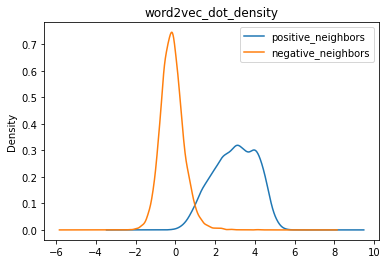

In [9]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [10]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.86it/s]


((14490, 2), 0.007904432974268278, 0.9941962974378775, 0.7350343179741146)

# word2vec+deepwalk+random

In [11]:
model = "word2vec+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


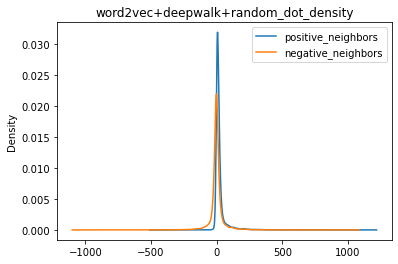

In [12]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [13]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 331.17it/s]


((14490, 2), 0.00163646886238919, 0.7403804395034017, 0.27647512686908077)

# deepwalk

In [14]:
model = "deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


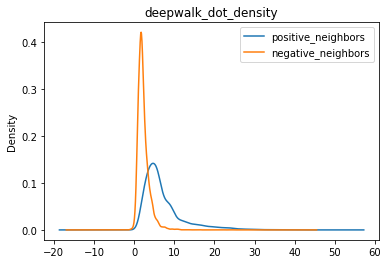

In [15]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [16]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 246.71it/s]


((14490, 2), 0.008204248868187674, 0.9045901584578607, 0.7509697389221832)

# node2vec

In [17]:
model = "node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


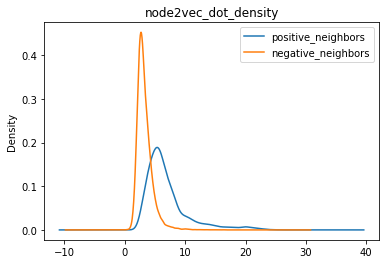

In [18]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [19]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 237.77it/s]


((14490, 2), 0.008198077390220961, 0.9048047529453864, 0.7473127144037034)

# fairwalk+deepwalk

In [20]:
model = "fairwalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


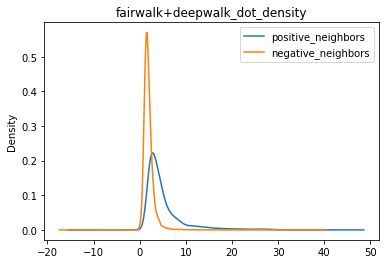

In [21]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [22]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 249.75it/s]


((14490, 2), 0.007780642096137762, 0.8837298048472224, 0.7300231898698476)

# fairwalk+node2vec

In [23]:
model = "fairwalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(2898, 128)

selected edge_idx size: 13702


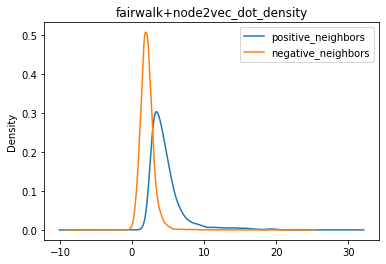

In [24]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [25]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 257.98it/s]


((14490, 2), 0.00782203413416894, 0.9313863940543462, 0.729928366400861)

# crosswalk+deepwalk

In [26]:
model = "crosswalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


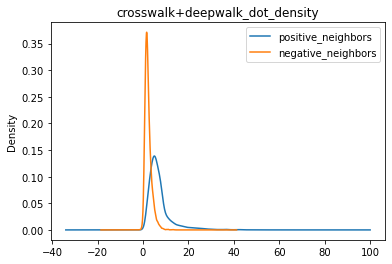

In [27]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [28]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 251.76it/s]


((14490, 2), 0.007842359445650503, 0.9049033815071654, 0.7365689454107479)

# crosswalk+node2vec

In [29]:
model = "crosswalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


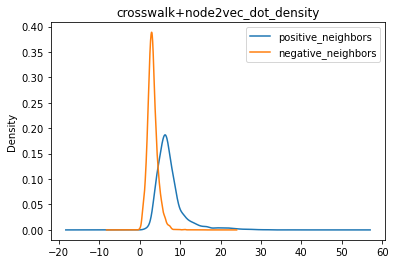

In [30]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [31]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.23it/s]


((14490, 2), 0.008216273391649381, 0.9416624707227583, 0.7474076010820809)

# GCN+deepwalk+random

In [32]:
model = "GCN+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


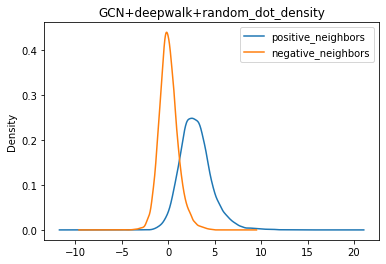

In [33]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [34]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 335.92it/s]


((14490, 2), 0.00806073500495291, 0.9412425096994961, 0.7457949478329597)

# GCN+deepwalk+r2v

In [35]:
model = "GCN+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(2898, 128)

selected edge_idx size: 13702


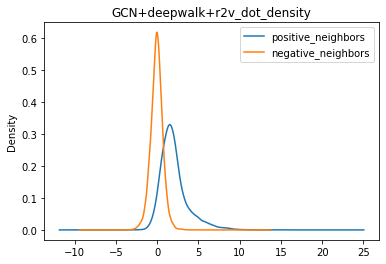

In [36]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [37]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 328.58it/s]


((14490, 2), 0.007289744587815994, 0.9135274018022892, 0.7216667129224854)

# GCN+node2vec+random

In [38]:
model = "GCN+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


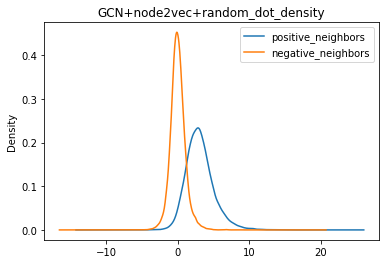

In [39]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [40]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 317.94it/s]


((14490, 2), 0.008111906750770748, 0.937667025927386, 0.7452505429513034)

# GCN+node2vec+r2v

In [41]:
model = "GCN+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


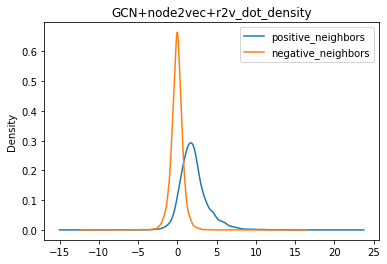

In [42]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [43]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 337.35it/s]


((14490, 2), 0.007934206631827118, 0.9017114050197628, 0.7345851636216072)

# GAT+deepwalk+random

In [44]:
model = "GAT+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


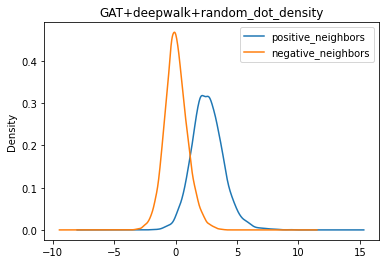

In [45]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [46]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 321.45it/s]


((14490, 2), 0.007889141509296116, 0.9506846964457137, 0.7438427928109538)

# GAT+deepwalk+r2v

In [47]:
model = "GAT+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


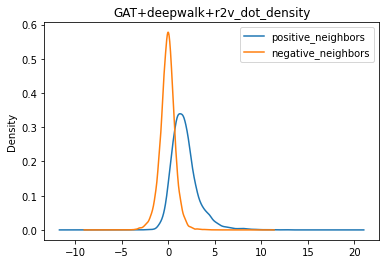

In [48]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [49]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 296.73it/s]


((14490, 2), 0.006638955173835768, 0.8985014653188483, 0.6868049853619786)

# GAT+node2vec+random

In [50]:
model = "GAT+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


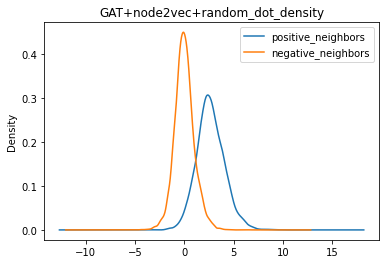

In [51]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [52]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 309.54it/s]


((14490, 2), 0.008123907993668552, 0.9419744793576286, 0.7442996006102365)

# GAT+node2vec+r2v

In [53]:
model = "GAT+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


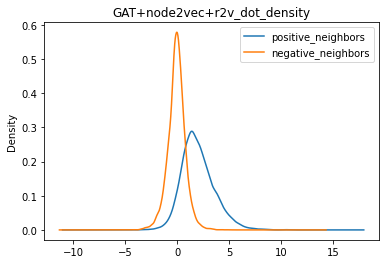

In [54]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [55]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 327.27it/s]


((14490, 2), 0.00774625803678076, 0.8942976578994964, 0.7272046244505459)

# plot statistical parity scores

# gini sp scores

word2vec 0.7350343179741146
word2vec+deepwalk+random 0.27647512686908077
deepwalk 0.7509697389221832
node2vec 0.7473127144037034
fairwalk+deepwalk 0.7300231898698476
fairwalk+node2vec 0.729928366400861
crosswalk+deepwalk 0.7365689454107479
crosswalk+node2vec 0.7474076010820809
GCN+deepwalk+random 0.7457949478329597
GCN+deepwalk+r2v 0.7216667129224854
GCN+node2vec+random 0.7452505429513034
GCN+node2vec+r2v 0.7345851636216072
GAT+deepwalk+random 0.7438427928109538
GAT+deepwalk+r2v 0.6868049853619786
GAT+node2vec+random 0.7442996006102365
GAT+node2vec+r2v 0.7272046244505459


Text(0.5, 1.0, 'gini statistical parity scores')

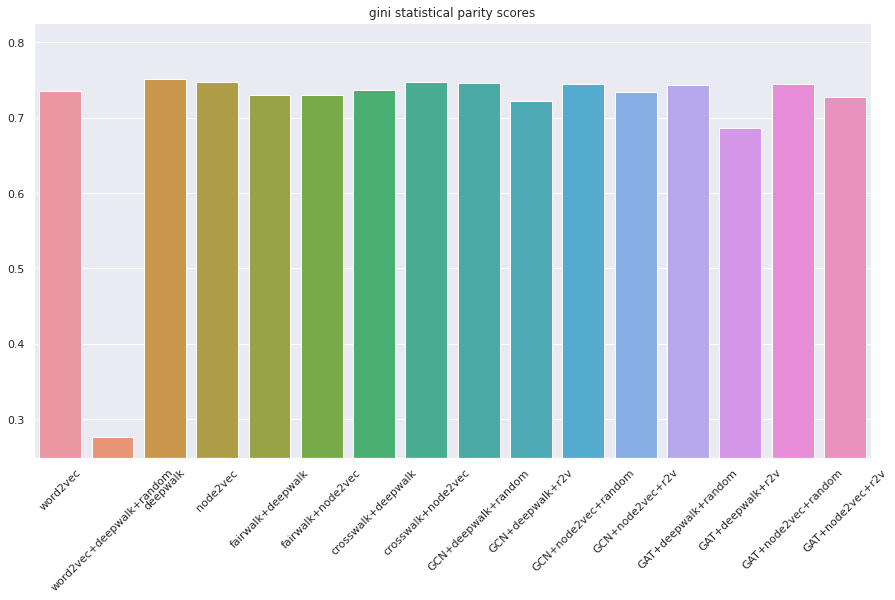

In [56]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9 , max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

word2vec 0.007904432974268278
word2vec+deepwalk+random 0.00163646886238919
deepwalk 0.008204248868187674
node2vec 0.008198077390220961
fairwalk+deepwalk 0.007780642096137762
fairwalk+node2vec 0.00782203413416894
crosswalk+deepwalk 0.007842359445650503
crosswalk+node2vec 0.008216273391649381
GCN+deepwalk+random 0.00806073500495291
GCN+deepwalk+r2v 0.007289744587815994
GCN+node2vec+random 0.008111906750770748
GCN+node2vec+r2v 0.007934206631827118
GAT+deepwalk+random 0.007889141509296116
GAT+deepwalk+r2v 0.006638955173835768
GAT+node2vec+random 0.008123907993668552
GAT+node2vec+r2v 0.00774625803678076


Text(0.5, 1.0, 'statistical parity scores')

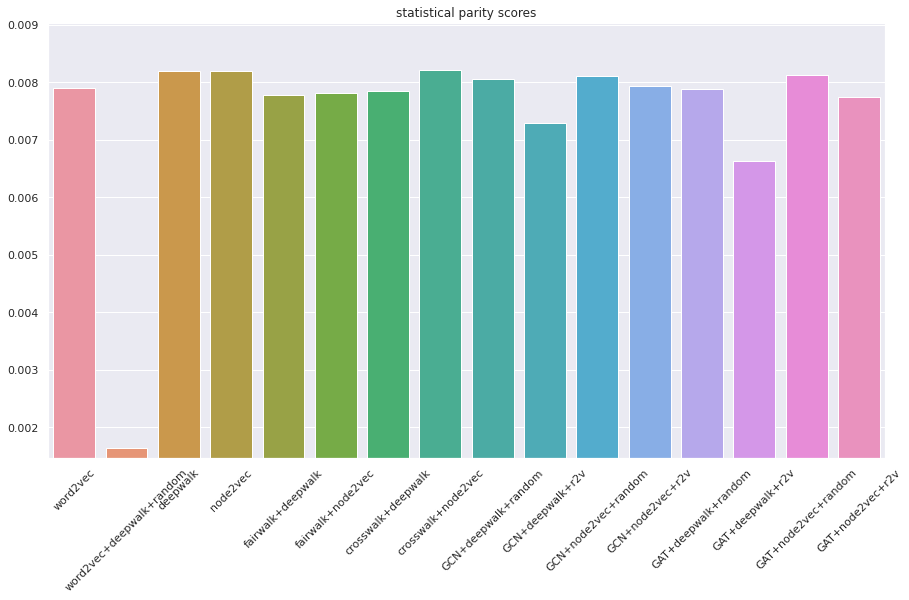

In [57]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

word2vec 0.9941962974378775
word2vec+deepwalk+random 0.7403804395034017
deepwalk 0.9045901584578607
node2vec 0.9048047529453864
fairwalk+deepwalk 0.8837298048472224
fairwalk+node2vec 0.9313863940543462
crosswalk+deepwalk 0.9049033815071654
crosswalk+node2vec 0.9416624707227583
GCN+deepwalk+random 0.9412425096994961
GCN+deepwalk+r2v 0.9135274018022892
GCN+node2vec+random 0.937667025927386
GCN+node2vec+r2v 0.9017114050197628
GAT+deepwalk+random 0.9506846964457137
GAT+deepwalk+r2v 0.8985014653188483
GAT+node2vec+random 0.9419744793576286
GAT+node2vec+r2v 0.8942976578994964


Text(0.5, 1.0, 'roc scores')

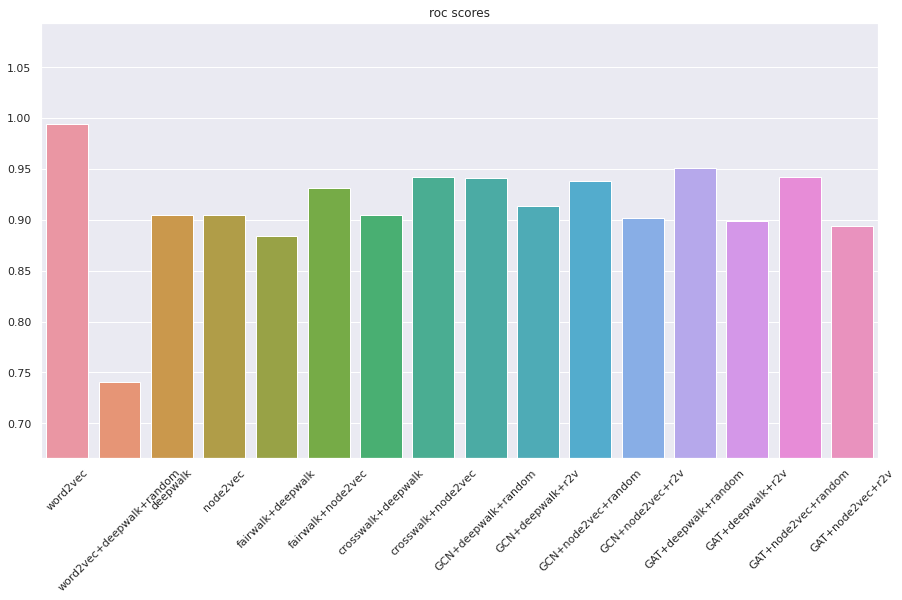

In [58]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [59]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        batch_size =  2000
        A = embs[m]
        edges = snakemake_utils.return_new_graph(A, k, )
        
    
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 326.51it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 259.37it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 197.77it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 262.05it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 261.96it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 277.79it/s]


Text(0.5, 1.0, 'gini scores vs # nn')

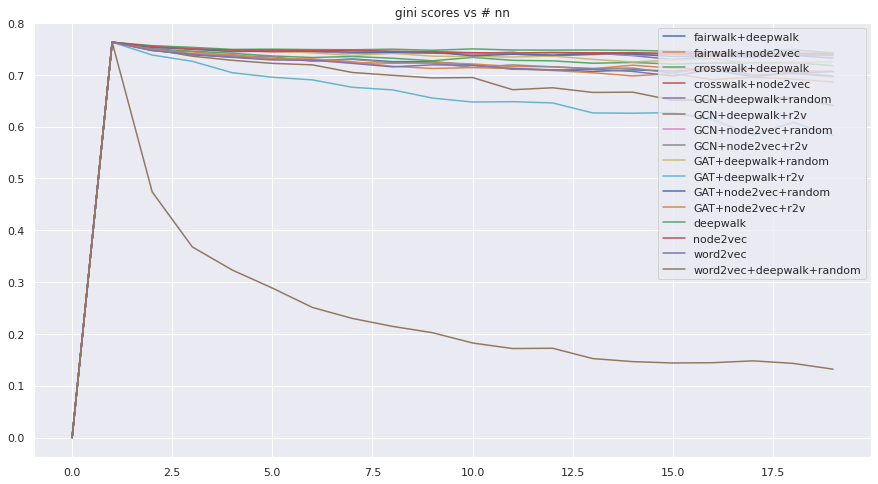

In [60]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

Text(0.5, 1.0, 'sp scores vs # nn')

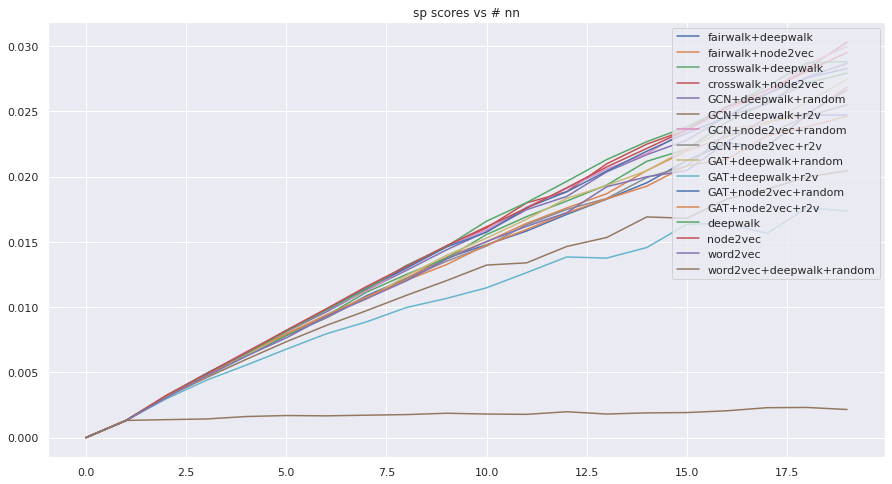

In [61]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [62]:

def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        file = DATA_ROOT + d + DATASET + '_test_adj.npz'
        dot = create_dot_df(A, file)
        scores[idx] = get_roc_score(dot)
    return scores


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        edges = snakemake_utils.return_new_graph(A, K)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return scores, scores_gini

selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected e

Text(0.5, 1.0, 'roc scores')

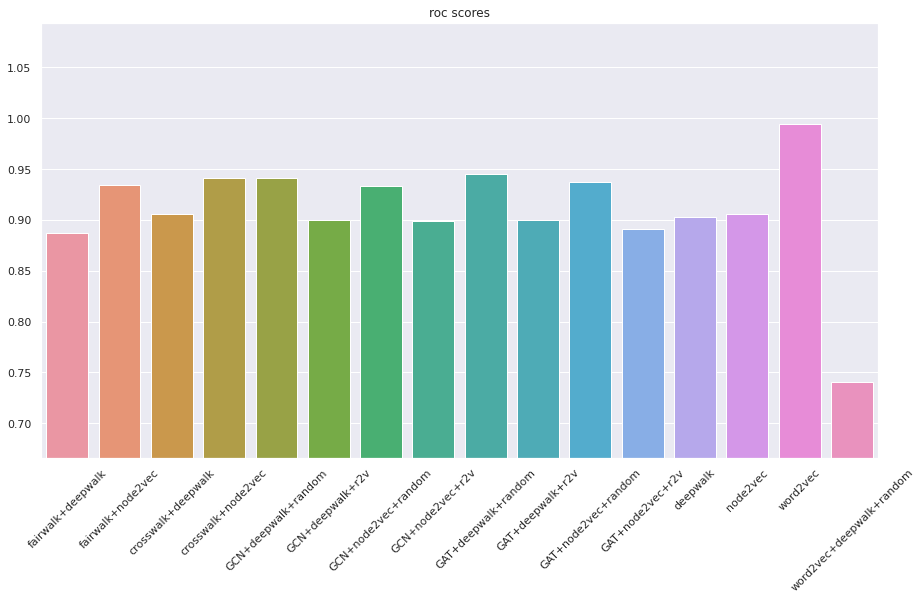

In [63]:

roc_score = {m: np.mean(roc_scores(m)) for m in model_to_embs}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 329.07it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 356.81it/s]

fairwalk+deepwalk 0.007769098057924169
fairwalk+node2vec 0.007794485866323119
crosswalk+deepwalk 0.007906591706756562
crosswalk+node2vec 0.00819511199926479
GCN+deepwalk+random 0.007979653893233468
GCN+deepwalk+r2v 0.007390599574952755
GCN+node2vec+random 0.008192216749369232
GCN+node2vec+r2v 0.007886316668868801
GAT+deepwalk+random 0.007907733046564346
GAT+deepwalk+r2v 0.006839529478472847
GAT+node2vec+random 0.008214637175279762
GAT+node2vec+r2v 0.007756816988221155
deepwalk 0.008159934127110802
node2vec 0.008273220746565018
word2vec 0.007710498150681297
word2vec+deepwalk+random 0.0016348122060256681


Text(0.5, 1.0, 'statistical parity scores')

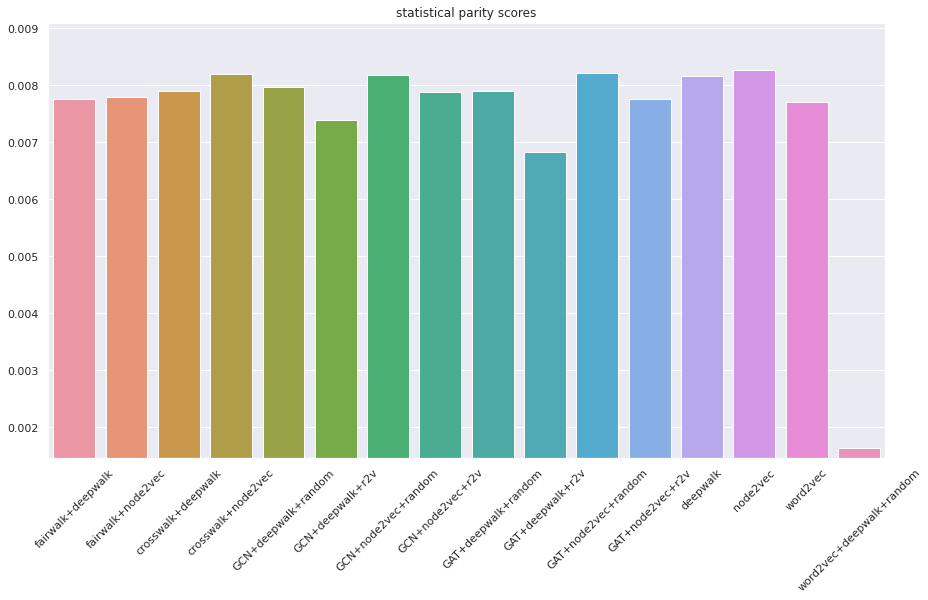

In [64]:

temp = {m: statisticalp_scores(m) for m in model_to_embs}

sp_score = {m: np.mean(v[0]) for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

fairwalk+deepwalk 0.7310966850775789
fairwalk+node2vec 0.7302599822388288
crosswalk+deepwalk 0.7401307255160605
crosswalk+node2vec 0.7454067610430879
GCN+deepwalk+random 0.7445923071659809
GCN+deepwalk+r2v 0.7214293509689503
GCN+node2vec+random 0.7459072900963821
GCN+node2vec+r2v 0.7340129676348153
GAT+deepwalk+random 0.7440277626505326
GAT+deepwalk+r2v 0.6990331029222246
GAT+node2vec+random 0.7461748498597325
GAT+node2vec+r2v 0.729816468049261
deepwalk 0.7492493274721248
node2vec 0.7479650452501125
word2vec 0.728448986065885
word2vec+deepwalk+random 0.28288172372433634


Text(0.5, 1.0, 'gini statistical parity scores')

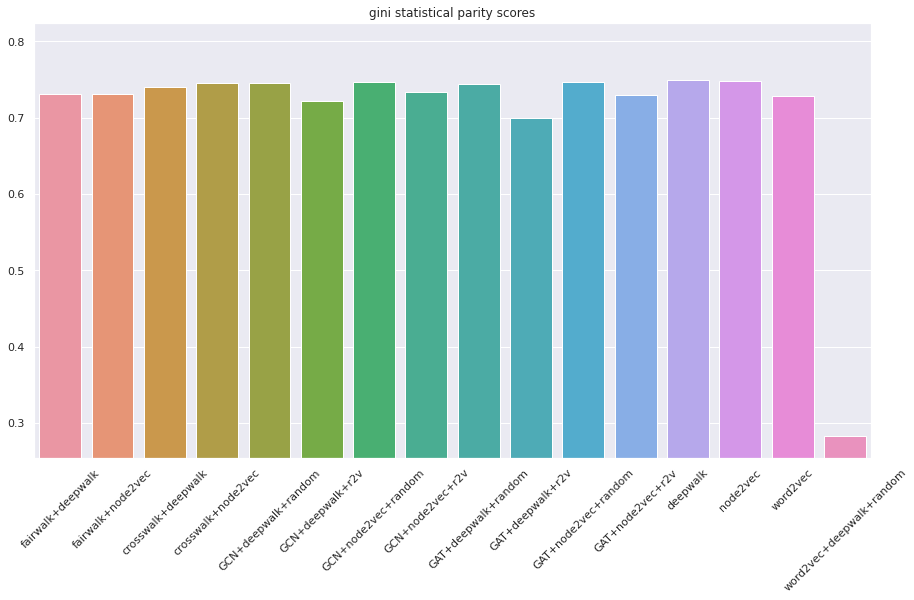

In [65]:
gini_score = {m: np.mean(v[1]) for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9, max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

In [66]:

# roc_score, sp_score, gini_score= {}, {}, {}
roc_score = {m: roc_scores(m) for m in model_to_embs}
temp = {m: statisticalp_scores(m) for m in model_to_embs}
sp_score = {m: v[0] for m,v in temp.items()}
gini_score = {m: v[1] for m,v in temp.items()}
pkl.dump(roc_score, open(DATA_ROOT + "roc_score.pkl", 'wb'))

pkl.dump(sp_score, open(DATA_ROOT + "sp_score.pkl", 'wb'))

pkl.dump(gini_score, open(DATA_ROOT + "gini_score.pkl", 'wb'))

selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected e

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 310.11it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 360.34it/s]
